# 01_EDA — Exploración de datos de facturas

Este cuaderno explora el ground-truth, construye/valida el `manifest.csv`, revisa distribuciones de campos, muestra ejemplos (incluyendo PDFs multipágina) y estima una métrica proxy de "calidad de OCR potencial".

Objetivos:
- Revisar distribución y formatos de `fecha`, `nit`, `razon_social`, `subtotal`, `iva_porcentaje`, `iva_valor`, `total`.
- Detectar faltantes/inconsistencias.
- Estimar densidad de texto y números, y presencia de palabras ancla (TOTAL, SUBTOTAL, IVA, NIT, RAZON SOCIAL/PROVEEDOR/CLIENTE).
- Visualizar histogramas/barras.



In [11]:
import os
import re
import json
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

random.seed(42)
np.random.seed(42)

ROOT = Path(os.getcwd())
# Normalizar raíz para evitar notebooks/data si se ejecuta desde notebooks/
if (ROOT.name == 'notebooks') and (ROOT.parent / 'data').exists():
    ROOT = ROOT.parent
else:
    for p in [ROOT] + list(ROOT.parents):
        if (p / 'data').exists():
            ROOT = p
            break
DATA_DIR = ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
GT_DIR = DATA_DIR / 'gt'
SPLITS_DIR = DATA_DIR / 'splits'
MANIFEST_PATH = DATA_DIR / 'manifest.csv'

GT_FIELDS = ['fecha','nit','razon_social','subtotal','iva_porcentaje','iva_valor','total']

def read_gt_records(gt_dir: Path):
    records = []
    for p in sorted(gt_dir.glob('*.json')):
        try:
            with open(p, 'r', encoding='utf-8') as f:
                obj = json.load(f)
            doc_id = obj.get('meta',{}).get('doc_id') or p.stem
            campos = obj.get('campos',{})
            rec = {'doc_id': doc_id, 'gt_path': str(p)}
            for k in GT_FIELDS:
                rec[f'gt_{k}'] = campos.get(k, None)
            records.append(rec)
        except Exception as e:
            print(f'[WARN] No se pudo leer {p}: {e}')
    return pd.DataFrame(records)

# Construir/validar manifest.csv

gt_df = read_gt_records(GT_DIR)
print(f'Total GT: {len(gt_df)}')

# Mapear doc_id a posibles archivos raw (robusto a ausencia y extensiones en mayúsculas)
raw_files = [p for p in RAW_DIR.iterdir() 
             if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.pdf'}]

raw_rows = []
for rf in sorted(raw_files):
    stem = rf.stem
    # soportar sufijos de multipágina (_p01, etc.) apuntando al doc base
    base_id = re.sub(r'_p\d+$', '', stem)
    raw_rows.append({'doc_base': base_id, 'raw_path': str(rf)})
raw_df = pd.DataFrame(raw_rows)

# Elegir una ruta representativa por doc_id si hay múltiples páginas
if raw_df.empty:
    print('[WARN] No se encontraron archivos en data/raw/. El manifest quedará sin rep_raw_path.')
    rep_raw = pd.DataFrame(columns=['doc_id', 'rep_raw_path'])
else:
    rep_raw = (raw_df.groupby('doc_base')['raw_path'].first().reset_index()
               .rename(columns={'doc_base':'doc_id','raw_path':'rep_raw_path'}))

manifest = pd.merge(gt_df, rep_raw, on='doc_id', how='left')
manifest['exists_raw'] = manifest['rep_raw_path'].apply(lambda x: os.path.exists(x) if isinstance(x,str) else False)

# Completar split si existe
if MANIFEST_PATH.exists():
    prev = pd.read_csv(MANIFEST_PATH)
    if 'split' in prev.columns:
        manifest = pd.merge(manifest, prev[['doc_id','split']], on='doc_id', how='left')
else:
    manifest['split'] = None

manifest.to_csv(MANIFEST_PATH, index=False)
print('Manifest guardado en', MANIFEST_PATH)
manifest.head()


Total GT: 103
Manifest guardado en c:\Users\kevin\Github\Project_IA\data\manifest.csv


,doc_id,gt_path,gt_fecha,gt_nit,gt_razon_social,gt_subtotal,gt_iva_porcentaje,gt_iva_valor,gt_total,rep_raw_path,exists_raw,split
0,factura_0001,c:\Users\kevin\Github\Project_IA\data\gt\factu...,2015-10-13,29284276-1,PARQUEADERO BIZERTA,NaN,NaN,NaN,7000,c:\Users\kevin\Github\Project_IA\data\raw\fact...,True,None
1,factura_0002,c:\Users\kevin\Github\Project_IA\data\gt\factu...,2025-10-18,901186632-1,EDS AMERICA YUMBO SARANTO S.A.S,NaN,NaN,NaN,51871,c:\Users\kevin\Github\Project_IA\data\raw\fact...,True,None
2,factura_0003,c:\Users\kevin\Github\Project_IA\data\gt\factu...,2025-10-13,1112148033-7,HOTEL BIZERTA,NaN,NaN,NaN,30000,c:\Users\kevin\Github\Project_IA\data\raw\fact...,True,None
3,factura_0004,c:\Users\kevin\Github\Project_IA\data\gt\factu...,2025-10-13,1115079400-1,VULCANIZADORA EL RETORNO S.A.S,NaN,NaN,NaN,35000,c:\Users\kevin\Github\Project_IA\data\raw\fact...,True,None
4,factura_0005,c:\Users\kevin\Github\Project_IA\data\gt\factu...,2013-10-13,29284276-1,PARQUEADERO BIZERTA,NaN,NaN,NaN,8000,c:\Users\kevin\Github\Project_IA\data\raw\fact...,True,None


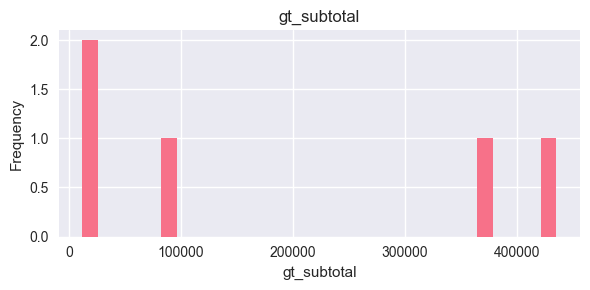

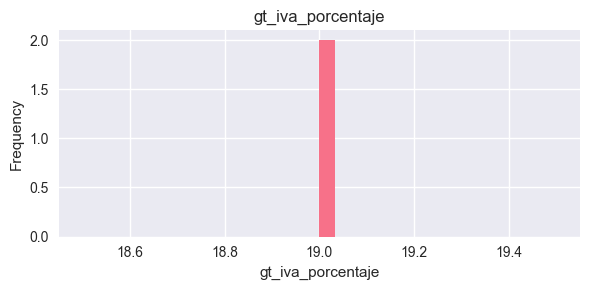

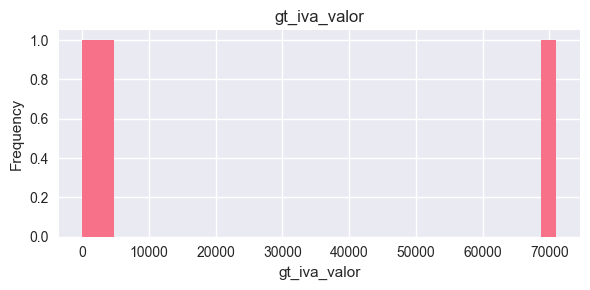

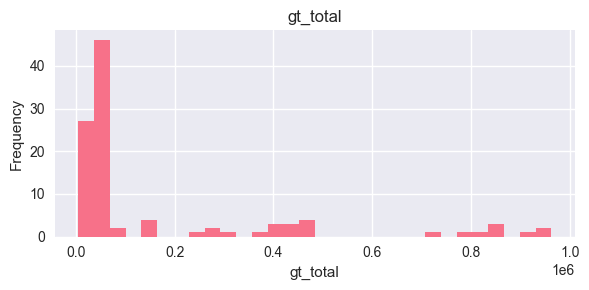

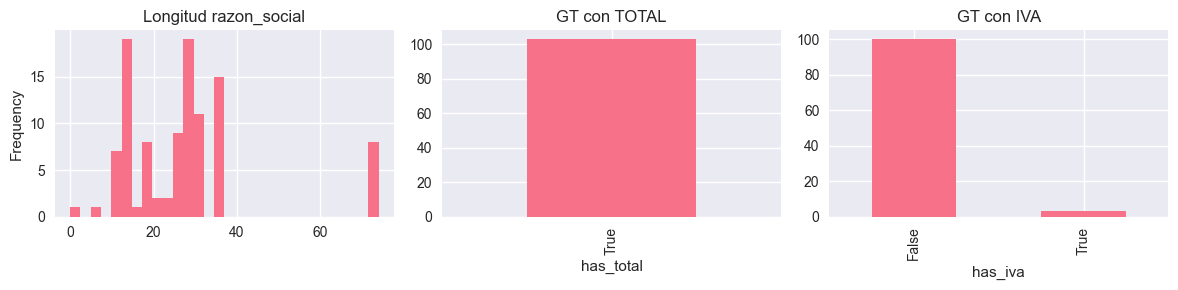

Registros sin archivo raw representativo: 0
Ejemplos para inspección manual: ['c:\\Users\\kevin\\Github\\Project_IA\\data\\raw\\factura_0031.jpg', 'c:\\Users\\kevin\\Github\\Project_IA\\data\\raw\\factura_0068.jpg', 'c:\\Users\\kevin\\Github\\Project_IA\\data\\raw\\factura_0063.jpg', 'c:\\Users\\kevin\\Github\\Project_IA\\data\\raw\\factura_0048.jpg', 'c:\\Users\\kevin\\Github\\Project_IA\\data\\raw\\factura_0043.jpg']


In [13]:
# Análisis de distribución de campos y calidad OCR potencial

from collections import Counter

def normalize_money(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int,float)):
        return float(x)
    s = str(x).strip().replace(' ', '')
    s = s.replace('.', '').replace(',', '.') if s.count(',')==1 and s.count('.')>1 else s
    s = re.sub(r'[^0-9\.-]', '', s)
    try:
        return float(s)
    except:
        return np.nan

plot_cols = ['gt_subtotal','gt_iva_porcentaje','gt_iva_valor','gt_total']
for c in plot_cols:
    if 'iva_porcentaje' in c:
        vals = pd.to_numeric(manifest[c], errors='coerce')
    else:
        vals = manifest[c].apply(normalize_money)
    plt.figure(figsize=(6,3))
    vals.dropna().plot(kind='hist', bins=30, title=c)
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

# Faltantes por campo
missing = {k: manifest[f'gt_{k}'].isna().mean() for k in GT_FIELDS}
missing

# Estimación de "calidad OCR potencial" por heurísticas del GT (proxy):
# densidad de dígitos en campos monetarios, longitud razon_social, presencia de palabras ancla teóricas.
anchor_words = ['TOTAL','SUBTOTAL','IVA','NIT','RAZON','SOCIAL','PROVEEDOR','CLIENTE']

manifest['len_razon'] = manifest['gt_razon_social'].fillna('').astype(str).str.len()
manifest['has_total'] = ~manifest['gt_total'].isna()
manifest['has_subtotal'] = ~manifest['gt_subtotal'].isna()
manifest['has_iva'] = (~manifest['gt_iva_valor'].isna()) | (~manifest['gt_iva_porcentaje'].isna())

fig, ax = plt.subplots(1,3, figsize=(12,3))
manifest['len_razon'].plot(kind='hist', bins=30, ax=ax[0], title='Longitud razon_social')
manifest['has_total'].value_counts().plot(kind='bar', ax=ax[1], title='GT con TOTAL')
manifest['has_iva'].value_counts().plot(kind='bar', ax=ax[2], title='GT con IVA')
plt.tight_layout(); plt.show()

print('Registros sin archivo raw representativo:', int((~manifest['exists_raw']).sum()))

# Muestras representativas (imprime rutas)
sample_paths = manifest[manifest['exists_raw']].sample(min(5, len(manifest[manifest['exists_raw']])) , random_state=42)['rep_raw_path'].tolist()
print('Ejemplos para inspección manual:', sample_paths)

